#  STEP 1: Dataset Download & Paths

In [ ]:

import kagglehub
import os

path = kagglehub.dataset_download(

    "masoudnickparvar/brain-tumor-mri-dataset"
)

TRAIN_DIR = os.path.join(path, "Training")
TEST_DIR  = os.path.join(path, "Testing")

print("Training classes:", os.listdir(TRAIN_DIR))
print("Testing classes :", os.listdir(TEST_DIR))


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Training classes: ['pituitary', 'notumor', 'meningioma', 'glioma']
Testing classes : ['pituitary', 'notumor', 'meningioma', 'glioma']


# STEP 2: Imports & Device

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


# STEP 3: Preprocessing & Augmentation

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# STEP 4: Dataset & Loaders

In [ ]:
full_train_dataset = datasets.ImageFolder(
    TRAIN_DIR, transform=train_transforms
)

test_dataset = datasets.ImageFolder(
    TEST_DIR, transform=test_transforms
)

class_names = full_train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)
train_size = int(0.8 * len(full_train_dataset))
val_size   = len(full_train_dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size], generator=generator
)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)



Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


# STEP 5: Data Visualization

## (a) Class Distribution

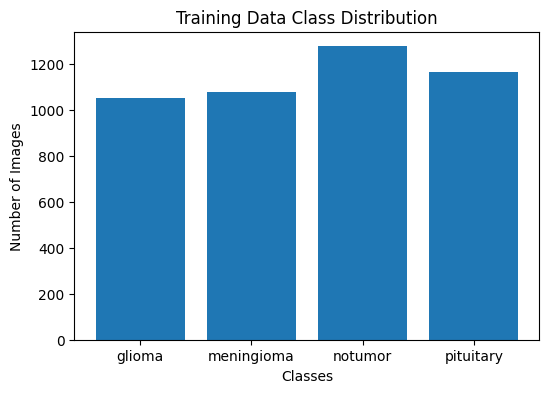

In [ ]:
# This plot shows the number of samples per tumor category.import matplotlib.pyplot as plt
from collections import Counter

labels = [label for _, label in train_dataset]
label_count = Counter(labels)

plt.figure(figsize=(6,4))
plt.bar(class_names, [label_count[i] for i in range(len(class_names))])
plt.title("Training Data Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()


## (b) Sample Images

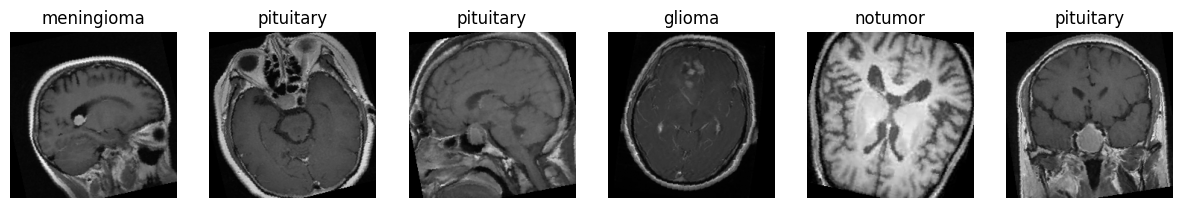

In [ ]:
def show_images(loader):
    images, labels = next(iter(loader))
    images, labels = images[:6], labels[:6]

    fig, axes = plt.subplots(1, 6, figsize=(15,3))
    for i in range(6):
        img = images[i].squeeze(0) * 0.5 + 0.5
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis("off")
    plt.show()

show_images(train_loader)


# STEP 6: CNN Model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((7,7))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# STEP 7: Loss & Optimizer

In [ ]:
model = SimpleCNN(num_classes).to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): AdaptiveAvgPool2d(output_size=(7, 7))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)


# STEP 8: TRAIN

In [ ]:
def train_model(epochs=25):
    train_accs, val_accs = [], []
    train_losses, val_losses = [], []

    for epoch in range(epochs):

        # -------- TRAINING --------
        model.train()
        correct, total = 0, 0
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # -------- VALIDATION --------
        model.eval()
        correct, total = 0, 0
        running_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total
        val_loss = running_loss / len(val_loader)

        val_accs.append(val_acc)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return train_accs, val_accs, train_losses, val_losses


In [ ]:
EPOCHS = 25
train_accs, val_accs,  train_losses, val_losses = train_model(EPOCHS)


Epoch [1/25] Train Acc: 66.19% | Val Acc: 75.85% Train Loss: 0.8442 | Val Loss: 0.6102
Epoch [2/25] Train Acc: 77.43% | Val Acc: 81.71% Train Loss: 0.5856 | Val Loss: 0.4638
Epoch [3/25] Train Acc: 81.68% | Val Acc: 81.71% Train Loss: 0.4903 | Val Loss: 0.4405
Epoch [4/25] Train Acc: 83.54% | Val Acc: 86.35% Train Loss: 0.4381 | Val Loss: 0.3509
Epoch [5/25] Train Acc: 84.31% | Val Acc: 86.44% Train Loss: 0.4100 | Val Loss: 0.3356
Epoch [6/25] Train Acc: 85.84% | Val Acc: 88.01% Train Loss: 0.3655 | Val Loss: 0.3146
Epoch [7/25] Train Acc: 87.31% | Val Acc: 88.80% Train Loss: 0.3365 | Val Loss: 0.2884
Epoch [8/25] Train Acc: 88.29% | Val Acc: 88.63% Train Loss: 0.3219 | Val Loss: 0.2890
Epoch [9/25] Train Acc: 88.51% | Val Acc: 91.08% Train Loss: 0.3061 | Val Loss: 0.2302
Epoch [10/25] Train Acc: 90.22% | Val Acc: 91.16% Train Loss: 0.2660 | Val Loss: 0.2341
Epoch [11/25] Train Acc: 90.46% | Val Acc: 91.60% Train Loss: 0.2612 | Val Loss: 0.2266
Epoch [12/25] Train Acc: 91.40% | Val Acc

In [ ]:
test_loss = 0.0

with torch.no_grad():
    correct, total = 0, 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()  # add batch loss

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
test_loss = test_loss / len(test_loader)  # average loss per batch

print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 96.03%
Test Loss: 0.1211


#  STEP 9: Loss & Accuracy Curves

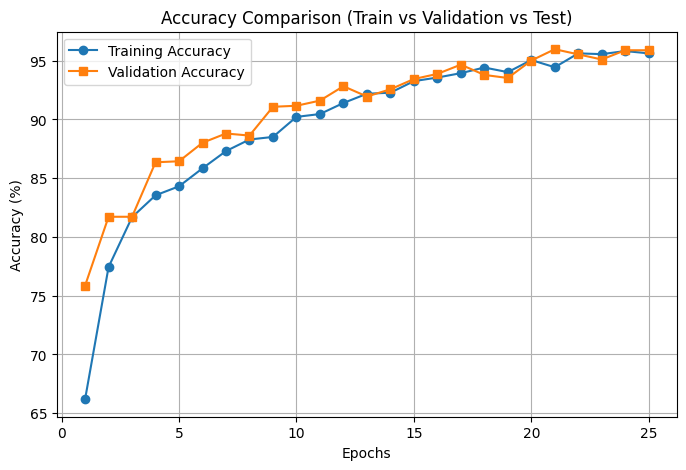

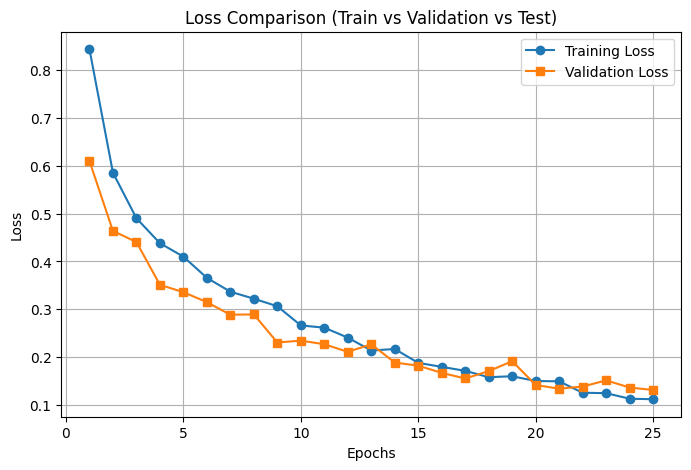

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

# ----- Accuracy Curve -----
plt.figure(figsize=(8,5))
plt.plot(epochs, train_accs, marker='o', label='Training Accuracy')
plt.plot(epochs, val_accs, marker='s', label='Validation Accuracy')

# If you tracked test accuracy per epoch
#if 'test_accs' in globals():
   # plt.plot(epochs, test_accs, marker='^', label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison (Train vs Validation vs Test)")
plt.legend()
plt.grid(True)
plt.show()

# ----- Loss Curve -----
plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses, marker='s', label='Validation Loss')

# If you tracked test loss per epoch
#if 'test_losses' in globals():
  #  plt.plot(epochs, test_losses, marker='^', label='Test Loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison (Train vs Validation vs Test)")
plt.legend()
plt.grid(True)
plt.show()


# STEP 11: Confusion Matrix & Classification Report

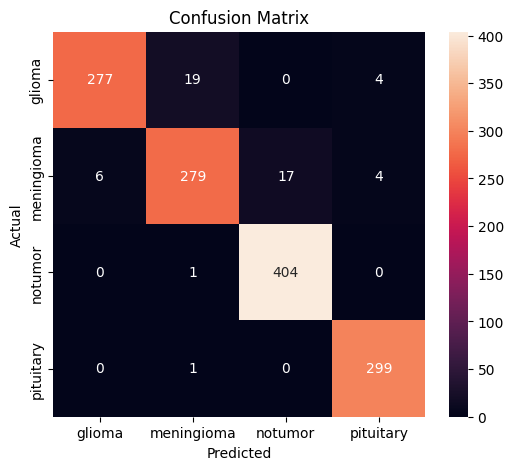

              precision    recall  f1-score   support

      glioma       0.98      0.92      0.95       300
  meningioma       0.93      0.91      0.92       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.97      1.00      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print(classification_report(all_labels, all_preds, target_names=class_names))


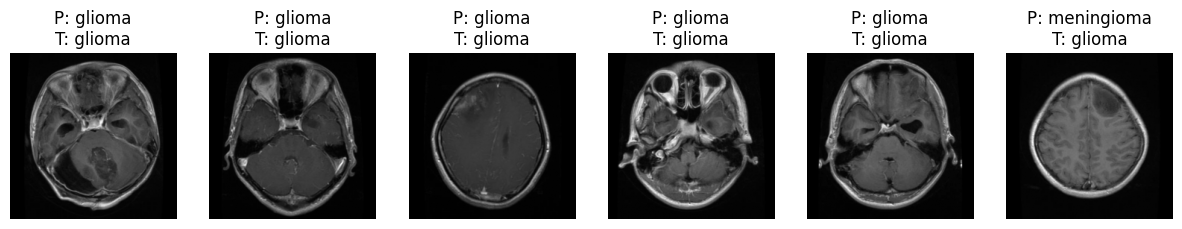

In [ ]:
def visualize_predictions():
    images, labels = next(iter(test_loader))
    images, labels = images[:6].to(device), labels[:6].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, 6, figsize=(15,3))
    for i in range(6):
        img = images[i].cpu().squeeze(0)
        img = img * 0.5 + 0.5   # unnormalize
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(
            f"P: {class_names[preds[i]]}\nT: {class_names[labels[i]]}"
        )
        axes[i].axis("off")

    plt.show()

visualize_predictions()


# STEP 10: Save & Load Model (.pth)

In [ ]:
torch.save(model.state_dict(), "brain_tumor_cnn.pth")
print("Model saved successfully!")


Model saved successfully!


# Load later:

In [ ]:
model.load_state_dict(torch.load("brain_tumor_cnn.pth"))
model.eval()


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): AdaptiveAvgPool2d(output_size=(7, 7))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [ ]:
from google.colab import files
from PIL import Image
import torch
from torchvision import transforms

# Upload image
uploaded = files.upload()  # opens a file chooser
for img_name in uploaded.keys():
    print(f"Uploaded file: {img_name}")

    # Predict function
    def predict_image(img_path):
        img = Image.open(img_path).convert('L')  # grayscale
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        img = transform(img).unsqueeze(0).to(device)  # add batch dim

        model.eval()
        with torch.no_grad():
            output = model(img)
            _, pred = torch.max(output, 1)
            print(f"Predicted Class: {class_names[pred.item()]}")

    # Call prediction
    predict_image(img_name)


Saving notum.jpg to notum (1).jpg
Uploaded file: notum (1).jpg
Predicted Class: notumor
